# MRI Görüntülerinden Beyin Tümörü Sınıflandırması

## Derin Öğrenme (FET312) - Final Proje Kod Dosyası

**Öğrenci:** Bilal Furkan Çakırgöz  
**Grup:** DevTe213  
**Hedef Model:** EfficientNet-B0 (Efficient Neural Networks)  

### Model Stratejisi: Compound Scaling ve Verimlilik
Bu notebook dosyasında, modelin derinliğini, genişliğini ve çözünürlüğünü rastgele değil, belirli bir katsayı ile dengeli bir şekilde ölçeklendiren **"Compound Scaling"** yöntemini kullanan **EfficientNet-B0** mimarisi tercih edilmiştir. Bu yapı, gereksiz parametre yığınından kaçınarak yüksek doğruluk ve verimlilik sağlar.

**Uygulanan Yöntem:**
1.  **Transfer Learning:** ImageNet veri seti üzerinde eğitilmiş ağırlıklar (Weights) kullanılarak modelin görsel algısı projeye transfer edilmiştir.
2.  **Feature Extraction (Dondurma):** Modelin temel konvolüsyon blokları dondurulmuş (`requires_grad=False`), böylece gelişmiş öznitelik çıkarma yeteneği korunmuştur.
3.  **Optimization & Fine-Tuning:** Son sınıflandırma katmanı (Classifier) projemizdeki 4 sınıf için yeniden yapılandırılmış ve veri setindeki dengesizliği (Imbalance) gidermek amacıyla **"Class Weighting" (Sınıf Ağırlıklandırma)** tekniği uygulanarak eğitim optimize edilmiştir.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import copy
import os
import gc
import json
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Hafiza Temizligi
gc.collect()
torch.cuda.empty_cache()

# Ayarlar
BATCH_SIZE = 16
IMG_SIZE = 224
LEARNING_RATE = 0.001
EPOCHS = 20
RANDOM_SEED = 213

# Seed Sabitleme
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Cihaz Secimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

Cihaz: cuda


In [2]:
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-2\training"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

try:
    full_dataset = datasets.ImageFolder(DATA_PATH, transform=data_transforms['train'])
    
    total_len = len(full_dataset)
    train_len = int(0.7 * total_len)
    val_len = int(0.15 * total_len)
    test_len = total_len - train_len - val_len

    train_data, val_data, test_data = torch.utils.data.random_split(
        full_dataset, [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )

    dataloaders = {
        'train': DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
        'val': DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
        'test': DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    }
    
    # --- Bias Sorununu Cozmek Icin Agirlik Hesaplama ---
    train_targets = [full_dataset.targets[i] for i in train_data.indices]
    classes = np.unique(train_targets)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_targets)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    
    print("-" * 30)
    print("VERI SETI BILGILERI")
    print("-" * 30)
    print(f"Toplam Goruntu Sayisi: {total_len}")
    print(f"Egitim Seti (Train)  : {len(train_data)}")
    print(f"Dogrulama Seti (Val) : {len(val_data)}")
    print(f"Test Seti (Test)     : {len(test_data)}")
    print(f"Sinif Isimleri       : {full_dataset.classes}")
    print("-" * 30)
    print(f"Not: Sinif Agirliklari Hesaplanmistir: {class_weights.cpu().numpy()}")

except Exception as e:
    print(f"HATA: {e}")

------------------------------
VERI SETI BILGILERI
------------------------------
Toplam Goruntu Sayisi: 5712
Egitim Seti (Train)  : 3998
Dogrulama Seti (Val) : 856
Test Seti (Test)     : 858
Sinif Isimleri       : ['glioma', 'meningioma', 'notumor', 'pituitary']
------------------------------
Not: Sinif Agirliklari Hesaplanmistir: [1.0689839  1.0724249  0.89081997 0.99058473]


In [3]:
print("Model hazirlaniyor...")
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Katmanlari Dondur
for param in model.parameters():
    param.requires_grad = False

# EfficientNet'te son katman 'classifier' blogunun 1. elemanidir (Dropout'tan sonra)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)

model = model.to(device)
print("Model GPU uzerine alindi.")

Model hazirlaniyor...
Model GPU uzerine alindi.


In [4]:
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

# Loss Fonksiyonu (Agirliklandirilmis)
criterion = nn.CrossEntropyLoss(weight=class_weights)

since = time.time() # Baslangic zamani
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# Sonuclari tutacagimiz sozluk
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"Egitim Basliyor... (20 Epoch)")

for epoch in range(EPOCHS):
    # Her epoch basinda hafiza temizligi
    gc.collect()
    torch.cuda.empty_cache()
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc.item())

        if phase == 'val':
            print(f'Epoch {epoch+1}/{EPOCHS} | Val Acc: {epoch_acc:.4f}')
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

# Egitim suresini hesapla
time_elapsed = time.time() - since
print("-" * 30)
print(f'Egitim Tamamlandi. Gecen Sure: {time_elapsed // 60:.0f} dakika {time_elapsed % 60:.0f} saniye')
print(f'En Iyi Validasyon Basarisi: {best_acc:.4f}')

print("-" * 30)
print("Veriler kaydediliyor...")

# 1. En iyi modeli kaydet (.pth dosyasi)
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'Furkan_EfficientNet_Final.pth')

# 2. Grafik verilerini kaydet (.json dosyasi)
with open('furkan_history.json', 'w') as f:
    json.dump(history, f)

print("ISLEM TAMAMLANDI.")
print("Model: Furkan_EfficientNet_Final.pth olarak kaydedildi.")
print("Gecmis: furkan_history.json olarak kaydedildi.")

Egitim Basliyor... (20 Epoch)
Epoch 1/20 | Val Acc: 0.8633
Epoch 2/20 | Val Acc: 0.8949
Epoch 3/20 | Val Acc: 0.8785
Epoch 4/20 | Val Acc: 0.9030
Epoch 5/20 | Val Acc: 0.8972
Epoch 6/20 | Val Acc: 0.9089
Epoch 7/20 | Val Acc: 0.9136
Epoch 8/20 | Val Acc: 0.9100
Epoch 9/20 | Val Acc: 0.9217
Epoch 10/20 | Val Acc: 0.9217
Epoch 11/20 | Val Acc: 0.9136
Epoch 12/20 | Val Acc: 0.9182
Epoch 13/20 | Val Acc: 0.9136
Epoch 14/20 | Val Acc: 0.9159
Epoch 15/20 | Val Acc: 0.9206
Epoch 16/20 | Val Acc: 0.9217
Epoch 17/20 | Val Acc: 0.9171
Epoch 18/20 | Val Acc: 0.9264
Epoch 19/20 | Val Acc: 0.9322
Epoch 20/20 | Val Acc: 0.9171
------------------------------
Egitim Tamamlandi. Gecen Sure: 11 dakika 31 saniye
En Iyi Validasyon Basarisi: 0.9322
------------------------------
Veriler kaydediliyor...
ISLEM TAMAMLANDI.
Model: Furkan_EfficientNet_Final.pth olarak kaydedildi.
Gecmis: furkan_history.json olarak kaydedildi.


Furkan grafik verileri yuklendi.


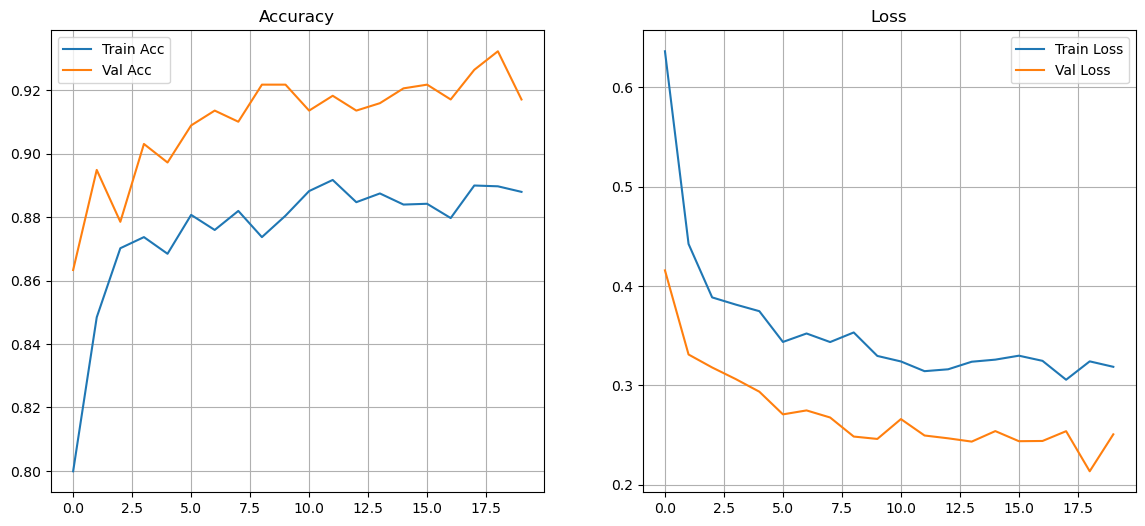

In [5]:
import json
import matplotlib.pyplot as plt

try:
    with open('furkan_history.json', 'r') as f:
        history_data = json.load(f)
    
    print("Furkan grafik verileri yuklendi.")
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy Grafigi
    plt.subplot(1, 2, 1)
    plt.plot(history_data['train_acc'], label='Train Acc')
    plt.plot(history_data['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss Grafigi
    plt.subplot(1, 2, 2)
    plt.plot(history_data['train_loss'], label='Train Loss')
    plt.plot(history_data['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

except FileNotFoundError:
    print("HATA: furkan_history.json dosyasi bulunamadi.")

Test islemi icin hazirlik yapiliyor...
Model agirliklari basariyla yuklendi.
Test seti analiz ediliyor...

SINIFLANDIRMA RAPORU
              precision    recall  f1-score   support

      glioma     0.9691    0.8177    0.8870       192
  meningioma     0.7500    0.8842    0.8116       190
     notumor     0.9432    0.9651    0.9540       258
   pituitary     0.9663    0.9220    0.9437       218

    accuracy                         0.9033       858
   macro avg     0.9072    0.8973    0.8991       858
weighted avg     0.9121    0.9033    0.9049       858



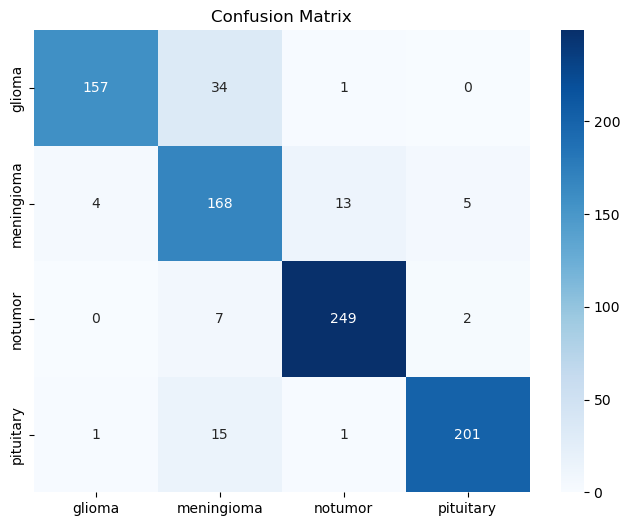

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc

# Hafiza Temizligi
gc.collect()
torch.cuda.empty_cache()

# Ayarlar
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-2\training"
BATCH_SIZE = 16
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Test islemi icin hazirlik yapiliyor...")

# Veri Setini Tekrar Tanimla (Sadece Test Icin)
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_PATH, transform=data_transforms)
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

# Seed ayni oldugu icin split ayni olacaktir
torch.manual_seed(213)
_, _, test_data_final = torch.utils.data.random_split(
    full_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(213)
)
test_loader = DataLoader(test_data_final, batch_size=BATCH_SIZE, shuffle=False)

# Modeli Kur 
model = models.efficientnet_b0(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)
model = model.to(device)

# Agirliklari Dosyadan Yukle
try:
    model.load_state_dict(torch.load('Furkan_EfficientNet_Final.pth', map_location=device))
    print("Model agirliklari basariyla yuklendi.")
    
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Test seti analiz ediliyor...")
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Rapor
    print("\nSINIFLANDIRMA RAPORU")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.title('Confusion Matrix')
    plt.show()

except FileNotFoundError:
    print("HATA: Furkan_EfficientNet_Final.pth dosyasi bulunamadi.")